In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2
import tensorflow as tf
from tensorflow import keras
import random
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Sequential, Model, Input

**PART -A:**

**DOMAIN:** Botanical Research

**CONTEXT:** University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at
various stages of growth. They already have have invested on curating sample images. They require an automation which can create a
classifier capable of determining a plant's species from a photo.



**PROJECT OBJECTIVE:**  To create a classifier capable of determining a plant's species from a photo.

1. Importing and Understanding data


In [ ]:
import zipfile as zipfile

In [ ]:
from zipfile import ZipFile

### 1.A

In [ ]:
with ZipFile("/content/drive/MyDrive/Colab Notebooks/CV Project/plant-seedlings-classification.zip", 'r') as zipobj:
 zipobj.extractall("/content/gdrive/MyDrive/Colab Notebooks/CV Project/unzipped") 

### 1.B

In [ ]:
dataset= ["/content/drive/MyDrive/Colab Notebooks/CV Project/unzipped/plant-seedlings-classification/train"]

In [ ]:
import glob
train_data = pd.DataFrame({'path' : glob.glob("/content/drive/MyDrive/Colab Notebooks/CV Project/unzipped/plant-seedlings-classification/train/*/*")})
train_data

,path
0,/content/drive/MyDrive/Colab Notebooks/CV Proj...
1,/content/drive/MyDrive/Colab Notebooks/CV Proj...
2,/content/drive/MyDrive/Colab Notebooks/CV Proj...
3,/content/drive/MyDrive/Colab Notebooks/CV Proj...
4,/content/drive/MyDrive/Colab Notebooks/CV Proj...
...,...
4745,/content/drive/MyDrive/Colab Notebooks/CV Proj...
4746,/content/drive/MyDrive/Colab Notebooks/CV Proj...
4747,/content/drive/MyDrive/Colab Notebooks/CV Proj...
4748,/content/drive/MyDrive/Colab Notebooks/CV Proj...


In [ ]:
train_data["path"][0].split("/")

['',
 'content',
 'drive',
 'MyDrive',
 'Colab Notebooks',
 'CV Project',
 'unzipped',
 'plant-seedlings-classification',
 'train',
 'Cleavers',
 '6a4ef17c2.png']

In [ ]:
# spliting only plant seedling and image name
train_data['label'] = train_data['path'].apply(lambda x : x.split('/')[-2])
train_data['picture']= train_data['path'].apply(lambda x: x.split("/")[-1])
train_data

,path,label,picture
0,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Cleavers,6a4ef17c2.png
1,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Cleavers,0515bc601.png
2,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Cleavers,0ac327873.png
3,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Cleavers,94f82e916.png
4,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Cleavers,2c5c4d127.png
...,...,...,...
4745,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Maize,b8b2658d9.png
4746,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Maize,edd80f8a8.png
4747,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Maize,8c71f9b84.png
4748,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Maize,fb6328acb.png


In [ ]:
# dataframe with images path, labels, and actual image.
train_data.head()

,path,label,picture
0,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Cleavers,6a4ef17c2.png
1,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Cleavers,0515bc601.png
2,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Cleavers,0ac327873.png
3,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Cleavers,94f82e916.png
4,/content/drive/MyDrive/Colab Notebooks/CV Proj...,Cleavers,2c5c4d127.png


In [ ]:
class_labels=["Black-grass","Charlock","Cleavers","Common Chickweed",
               "Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed",
               "Shepherds Purse","Small-flowered Cranesbill","Sugar beet"]

class_names_list= {class_name:i for i,class_name in enumerate(class_labels)}
print("Class names with labels: ")
class_names_list

Class names with labels: 


{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [ ]:
from tqdm import tqdm

# creating a function for train images and labels

def plant_species():
    images,labels = [],[]

    for data in dataset:

        for species in os.listdir(data):
            label = class_names_list[species] 
            
            for file in tqdm(os.listdir(os.path.join(data,species))):
                
                img_path = os.path.join(os.path.join(data,species),file)
                img = cv2.imread(img_path)

                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img,(150,150))
                
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)
        labels = np.array(labels,dtype=np.float32)
        
        pass
    
    return images,labels

In [ ]:
(train_images), (train_labels)=plant_species()

100%|██████████| 221/221 [00:06<00:00, 34.96it/s]


In [ ]:
train_images.shape

(4750, 150, 150, 3)

In [ ]:
train_labels.shape

(4750,)

In [ ]:
np.unique(train_labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
      dtype=float32)

### 1.C

In [ ]:
# function that will select radom images and display them along with labels

def display_image(input):
  
  for i in range(0,input):

    n=random.randint(1,4750)

    image_plant=tf.keras.preprocessing.image.array_to_img(train_images[n])

    print("class labels for image is : ", train_labels[n])

    print(" ")

    display(image_plant)


    print("******************************************************")

    continue

  


class labels for image is :  11.0
 


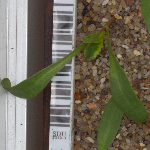

******************************************************
class labels for image is :  5.0
 


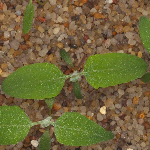

******************************************************
class labels for image is :  5.0
 


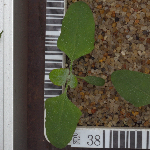

******************************************************
class labels for image is :  2.0
 


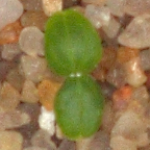

******************************************************
class labels for image is :  6.0
 


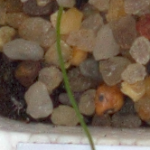

******************************************************


In [ ]:
display_image(5)

In [ ]:
n_train = train_labels.shape[0]

n_train, train_count = np.unique(train_labels,return_counts=True)

df = pd.DataFrame(data = train_count)

df['Index'] = class_labels
df.columns = ['Count','Species']
df

,Count,Species
0,263,Black-grass
1,390,Charlock
2,287,Cleavers
3,611,Common Chickweed
4,221,Common wheat
5,475,Fat Hen
6,654,Loose Silky-bent
7,221,Maize
8,516,Scentless Mayweed
9,231,Shepherds Purse


Text(0.5, 1.0, 'Plant-Species')

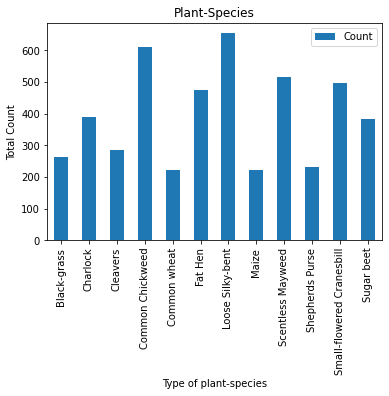

In [ ]:
df.set_index("Species").plot.bar()
plt.xlabel("Type of plant-species")
plt.ylabel("Total Count")
plt.title("Plant-Species")

## 2. Data Preprocessing: 

### 2.A 

In [ ]:
X= train_images
y= train_labels

### 2.B

In [ ]:
# encoding labels of all the images
# already done before

y

array([2., 2., 2., ..., 7., 7., 7.], dtype=float32)

### 2.C

In [ ]:
# unifying all images

y=to_categorical(y, num_classes=12)
y.shape

(4750, 12)

### 2.D

In [ ]:
# Normalising all the images

# maximum value of pixel
print("Maximum value of pixel in data - ", X.max())
print("\n")
print("Minimum value of pixel in data- ", X.min())

Maximum value of pixel in data -  255.0


Minimum value of pixel in data-  0.0


In [ ]:
X_data= (X/255.0).astype(np.float32)

## 3. Model Training

### 3.A

In [ ]:
# splitting data into train and test sets

X_train, X_test, y_train, y_test= train_test_split(X_data, y, test_size=0.2, random_state=3)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3800, 150, 150, 3)
(950, 150, 150, 3)
(3800, 12)
(950, 12)


### 3.B

### Creating CNN Architecture

In [ ]:
#Clear any existing model in memory
tf.keras.backend.clear_session()

#Initialize model, reshape & normalize data
model = tf.keras.models.Sequential()

#normalize data
model.add(tf.keras.layers.BatchNormalization(input_shape=(150,150,3,)))

In [ ]:
#Clear any previous model from memory
tf.keras.backend.clear_session()

#Initialize model
model = tf.keras.models.Sequential()

#normalize data
model.add(tf.keras.layers.BatchNormalization(input_shape=(150,150,3,)))

#Add Conv Layer
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization(input_shape=(150,150,3,)))

#Add Conv Layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization(input_shape=(150,150,3,)))

#Add Max Pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add Dense Layers after flattening the data
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))

#Add Dropout
model.add(tf.keras.layers.Dropout(0.25))

#Add Output Layer
model.add(tf.keras.layers.Dense(12, activation='softmax'))

### Compiling Model 

In [ ]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
#model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 150, 150, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_1 (Batc  (None, 148, 148, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 batch_normalization_2 (Batc  (None, 146, 146, 64)     256       
 hNormalization)                                                 
                                                        

### 3.C

In [ ]:

#Train the model
model.fit(X_train, y_train,          
          validation_data=(X_test, y_test),
          epochs=10,
          batch_size=32)

Epoch 1/10
119/119 [==============================] - 495s 4s/step - loss: 16.0487 - accuracy: 0.2050 - val_loss: 477.0431 - val_accuracy: 0.1168
Epoch 2/10
119/119 [==============================] - 494s 4s/step - loss: 2.5191 - accuracy: 0.2329 - val_loss: 368.4687 - val_accuracy: 0.1211
Epoch 3/10
119/119 [==============================] - 504s 4s/step - loss: 2.2900 - accuracy: 0.2392 - val_loss: 83.6097 - val_accuracy: 0.1568
Epoch 4/10
119/119 [==============================] - 504s 4s/step - loss: 2.2278 - accuracy: 0.2463 - val_loss: 5.1540 - val_accuracy: 0.2600
Epoch 5/10
119/119 [==============================] - 501s 4s/step - loss: 2.1992 - accuracy: 0.2650 - val_loss: 2.4715 - val_accuracy: 0.2758
Epoch 6/10
119/119 [==============================] - 499s 4s/step - loss: 2.3567 - accuracy: 0.2655 - val_loss: 2.8005 - val_accuracy: 0.2979
Epoch 7/10
119/119 [==============================] - 498s 4s/step - loss: 2.4075 - accuracy: 0.2571 - val_loss: 2.2588 - val_accuracy: 

Conclusions: 
1. CNN model could achieve 32% accuracy on test data.
2. Accuracy may increase after increasing number of epochs.

### 3.D

### **Part B**

**DOMAIN:** Botanical Research

**CONTEXT:** University X is currently undergoing some research involving understanding the characteristics of flowers. They already have
have invested on curating sample images. They require an automation which can create a classifier capable of determining a flower’s
species from a photo.

**DATA DESCRIPTION:** The dataset comprises of images from 17 plant species.

**PROJECT OBJECTIVE:** To experiment with various approaches to train an image classifier to predict type of flower from the image.

In [2]:
pip install tflearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 107 kB 5.3 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=dcf26e42c052603a3457c7662f222cbdc98018ddcc8619c7c2e37f3496688c05
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn


### 1.A

In [3]:
import tflearn.datasets.oxflower17 as oxflower17
X1, Y1 = oxflower17.load_data()

Instructions for updating:
non-resource variables are not supported in the long term


100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


In [4]:
X1.shape

(1360, 224, 224, 3)

In [5]:
Y1.shape

(1360,)

### 1.B

In [ ]:
print("Number of images are: ", X1.shape[0])
print(" ")
print("Shape of images are: ", X1.shape[1:])

Number of images are:  1360
 
Shape of images are:  (224, 224, 3)


In [6]:
class_labels= np.unique(Y1)

In [7]:
count= np.bincount(Y1)

### 1.C 

In [8]:
pd.DataFrame( {'class' :class_labels, 'count': count, })

,class,count
0,0,80
1,1,80
2,2,80
3,3,80
4,4,80
5,5,80
6,6,80
7,7,80
8,8,80
9,9,80


Inference: 
There are 17 differet classes with each flower count of 80

### 2.A

Image number :  1152


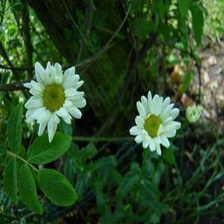

**********************************************
Image number :  608


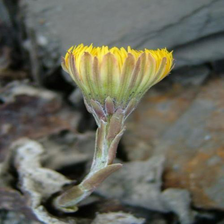

**********************************************
Image number :  1103


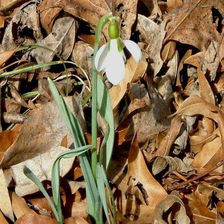

**********************************************
Image number :  265


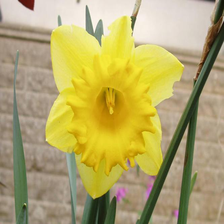

**********************************************
Image number :  418


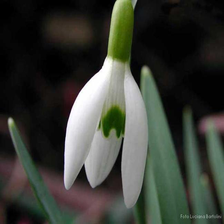

**********************************************


In [ ]:
for i in range(0,5):

    n=random.randint(1,1360)

    print("Image number : ", n)

    image_flower=tf.keras.preprocessing.image.array_to_img(X1[n])

    display(image_flower)
    print("**********************************************")


### 2.B 

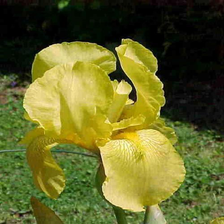

In [ ]:
image2=X1[250]
flower_variable =tf.keras.preprocessing.image.array_to_img(image2)
flower_variable

### 2.C

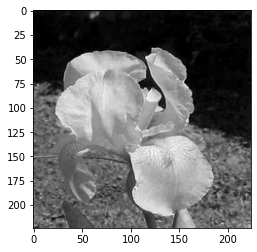

In [ ]:
# Using gray scale conversion formula
R, G, B = image2[:,:,0], image2[:,:,1], image2[:,:,2]
imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
plt.imshow(imgGray, cmap='gray')
plt.show()

### 2.D

Unsharpened image is : 


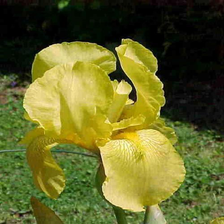

In [ ]:

from PIL import ImageFilter

# Apply sharp filter

#displaying unsharpened image

print("Unsharpened image is : ")
flower_variable

Sharpened image is : 


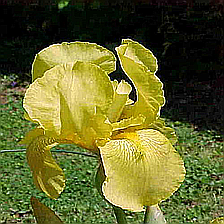

In [ ]:
sharpened1 = flower_variable.filter(ImageFilter.SHARPEN);
sharpened2= sharpened1.filter(ImageFilter.SHARPEN)
print("Sharpened image is : ")
sharpened2

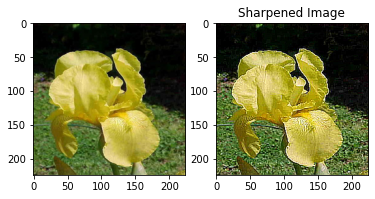

In [ ]:
# display images
fig, ax = plt.subplots(1,2)

ax[0].imshow(flower_variable)
plt.title("Sharpened Image")
ax[1].imshow(sharpened2)

### 2.E

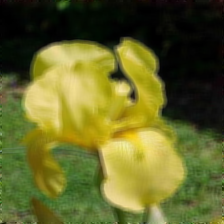

In [ ]:
# Applying blur filter on images

# Apply filter
BlurImage = flower_variable.filter(ImageFilter.BLUR)
# show the blur image
BlurImage

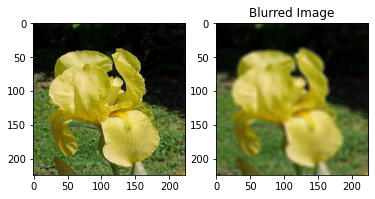

In [ ]:
# displaying original and blurred image side by side

# display images
fig, ax = plt.subplots(1,2)

ax[0].imshow(flower_variable)
plt.title("Blurred Image")
ax[1].imshow(BlurImage)

### 2.F

Text(0.5, 1.0, 'Blurred Image')

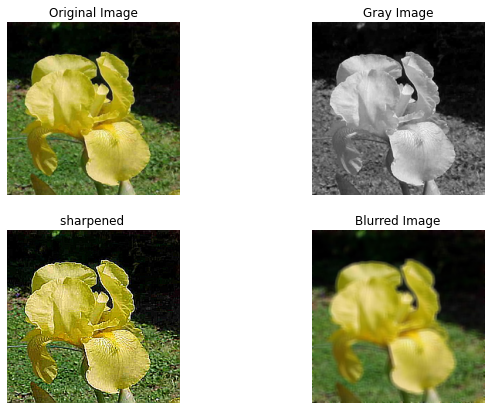

In [ ]:
# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 2
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(flower_variable)
plt.axis('off')
plt.title("Original Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(imgGray, cmap='gray')
plt.axis('off')
plt.title("Gray Image")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(sharpened2)
plt.axis('off')
plt.title("sharpened ")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(BlurImage)
plt.axis('off')
plt.title("Blurred Image")

Inference: 

Clear differences can be observed between gray image, sharpened and blurred image. 

### 3. Model Training and Tuning

### 3.A

In [9]:
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=7)

print(x1_train.shape)
print(x1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(1088, 224, 224, 3)
(272, 224, 224, 3)
(1088,)
(272,)


### 3.B

In [10]:
# Converting 4D data to 2D data shape

# converting train dataset into 2d shape 
nsamples, nx, ny, nrgb = x1_train.shape
x1_train2 = x1_train.reshape((nsamples,nx*ny*nrgb))

# converting test dataset into 2d shape
nsamples, nx, ny, nrgb = x1_test.shape
x1_test2 = x1_test.reshape((nsamples,nx*ny*nrgb))

In [11]:
x1_train2.shape

(1088, 150528)

In [15]:
# Training model on supervised learning algorithm

from sklearn.ensemble import RandomForestClassifier

model_supervised=RandomForestClassifier()

model_supervised.fit(x1_train2,y1_train)

RandomForestClassifier()

In [16]:
y_pred=model_supervised.predict(x1_test2)
y_pred


array([13,  4,  5,  1,  8,  4,  9,  5,  5, 11,  6,  7,  8,  6,  7,  9,  8,
        9, 16, 10,  6,  8,  8, 13, 10,  3,  2, 12,  7, 12, 13,  5,  5, 15,
        0, 10, 11,  8,  0, 16, 16, 16, 10, 16, 15, 14,  2,  7,  4,  3, 10,
        6, 12,  2,  5, 13,  5,  2, 10,  1,  1, 12, 16, 11, 11,  6,  0,  4,
        3,  5,  1, 10,  7, 12,  0,  0, 12, 15,  9, 16, 14,  4,  4,  9,  8,
        2,  4,  4,  2,  5, 14,  4, 13,  5, 10,  8,  6,  7,  6, 15,  2, 14,
       16,  2,  9,  3,  7,  1, 11, 11,  4,  7, 13, 12,  9,  8,  9, 12, 12,
        7,  0,  2, 12, 16,  5,  5,  9, 10,  4, 15, 16,  7,  5, 16,  3, 15,
        8, 15,  4,  4,  7,  9, 13, 12, 13, 14,  7, 13, 15,  6, 11, 16, 10,
        7,  5,  0,  1,  0,  5, 12,  4,  0,  6,  4, 12, 12, 16,  9,  3, 15,
        2, 16,  4,  5,  5,  0,  4,  2,  1,  9,  6,  5, 13, 13,  2, 16,  0,
        0,  6,  3, 13, 15,  3, 12, 16,  6, 16,  4,  0,  1, 15, 14,  0,  4,
       13, 10,  2, 14, 16, 11, 10,  5,  5,  4, 10,  9, 15,  5, 15,  7,  4,
       11, 10,  2,  9,  2

In [17]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
accuracy_score(y_pred,y1_test)
print(classification_report(y_pred,y1_test))

              precision    recall  f1-score   support

           0       0.40      0.40      0.40        15
           1       0.17      0.25      0.20        12
           2       0.69      0.65      0.67        17
           3       0.28      0.56      0.37         9
           4       0.73      0.35      0.47        23
           5       0.31      0.17      0.22        24
           6       0.47      0.60      0.53        15
           7       0.61      0.65      0.63        17
           8       0.75      0.46      0.57        13
           9       0.25      0.21      0.23        19
          10       0.65      0.68      0.67        19
          11       0.36      0.45      0.40        11
          12       0.62      0.62      0.62        16
          13       0.62      0.62      0.62        16
          14       0.00      0.00      0.00         8
          15       0.35      0.38      0.36        16
          16       0.95      0.82      0.88        22

    accuracy              

In [18]:
confusion_matrix(y_pred,y1_test)

array([[ 6,  0,  0,  2,  0,  1,  2,  0,  1,  0,  0,  0,  0,  0,  3,  0,
         0],
       [ 0,  3,  3,  0,  0,  1,  0,  1,  0,  3,  1,  0,  0,  0,  0,  0,
         0],
       [ 0,  0, 11,  0,  0,  0,  0,  5,  0,  1,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  0,  0,
         1],
       [ 3,  0,  0,  4,  8,  1,  6,  0,  0,  0,  0,  0,  0,  0,  1,  0,
         0],
       [ 2,  1,  0,  0,  1,  4,  0,  0,  0,  5,  0,  0,  0,  1,  8,  2,
         0],
       [ 0,  0,  0,  2,  1,  0,  9,  0,  0,  0,  0,  0,  0,  1,  2,  0,
         0],
       [ 1,  2,  0,  0,  0,  0,  0, 11,  0,  0,  1,  1,  1,  0,  0,  0,
         0],
       [ 1,  2,  1,  0,  0,  0,  1,  0,  6,  0,  0,  1,  0,  0,  0,  1,
         0],
       [ 0,  4,  1,  1,  0,  3,  0,  0,  0,  4,  3,  1,  1,  0,  1,  0,
         0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0, 13,  3,  0,  0,  1,  1,
         0],
       [ 0,  1,  0,  0,  0,  0,  0,  1,  0,  1,  1,  5,  0,  0,  

##**#Conclusion**:
 RandomForestClassifier shows 47% accuracy on the test data set. 

### 3.C

In [ ]:
# first normalizing pixels

x1_train=x1_train/255
x1_test=x1_test/255

# one hot encoding for y labels
y1_train = to_categorical(y1_train, num_classes=17)
y1_test = to_categorical(y1_test, num_classes=17)

In [ ]:
#reshaping traiN and test data for NN model

Xnn_train = x1_train.reshape((x1_train.shape[0], 224*224*3 )).astype('float32')
Xnn_test = x1_test.reshape((x1_test.shape[0], 224*224*3)).astype('float32')

In [ ]:
Xnn_train.shape

(1088, 150528)

In [ ]:
y1_train.shape

(1088, 17)

In [ ]:
y1_test.shape

(272, 17)

In [ ]:

# creating model 
nn_classifier= Sequential()

nn_classifier.add(Dense(32, input_dim = 224*224*3, activation= 'relu'))

nn_classifier.add(Dense(64, activation = 'relu'))

nn_classifier.add(Dense(17, activation = 'softmax'))

nn_classifier.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 32)                4816928   
                                                                 
 dense_18 (Dense)            (None, 64)                2112      
                                                                 
 dense_19 (Dense)            (None, 17)                1105      
                                                                 
Total params: 4,820,145
Trainable params: 4,820,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Specify Loss and Optimizer
nn_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
nn_classifier.fit(Xnn_train, y1_train, validation_data=(Xnn_test, y1_test), epochs=20, batch_size=32)

Train on 1088 samples, validate on 272 samples
Epoch 1/20
1088/1088 - 2s - loss: 1.5217 - acc: 0.4945 - val_loss: 1.8139 - val_acc: 0.4044 - 2s/epoch - 2ms/sample
Epoch 2/20
1088/1088 - 2s - loss: 1.4625 - acc: 0.5303 - val_loss: 1.7985 - val_acc: 0.4007 - 2s/epoch - 2ms/sample
Epoch 3/20
1088/1088 - 1s - loss: 1.4241 - acc: 0.5450 - val_loss: 1.7698 - val_acc: 0.4007 - 1s/epoch - 1ms/sample
Epoch 4/20
1088/1088 - 2s - loss: 1.3517 - acc: 0.5588 - val_loss: 1.7638 - val_acc: 0.4191 - 2s/epoch - 1ms/sample
Epoch 5/20
1088/1088 - 2s - loss: 1.3029 - acc: 0.5974 - val_loss: 1.7903 - val_acc: 0.3897 - 2s/epoch - 2ms/sample
Epoch 6/20
1088/1088 - 2s - loss: 1.2751 - acc: 0.5983 - val_loss: 1.7511 - val_acc: 0.3640 - 2s/epoch - 2ms/sample
Epoch 7/20
1088/1088 - 2s - loss: 1.1896 - acc: 0.6333 - val_loss: 1.7222 - val_acc: 0.3897 - 2s/epoch - 1ms/sample
Epoch 8/20
1088/1088 - 2s - loss: 1.1675 - acc: 0.6425 - val_loss: 1.7045 - val_acc: 0.3897 - 2s/epoch - 2ms/sample
Epoch 9/20
1088/1088 - 2s

**Inference:**

Neural network model shows 80% accuracy on train data and 
40% accuracy on test set after 20 epochs. 

### 3.D

### Basic CNN model 

In [ ]:
#Clear any previous model from memory
tf.keras.backend.clear_session()

img_size= 224

#Initialize model
model_CNN = tf.keras.models.Sequential()

# add input layer



#normalize data
model_CNN.add(tf.keras.layers.BatchNormalization(input_shape=(img_size,img_size,3,)))

#Add Conv Layer
model_CNN.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))

#normalize data
model_CNN.add(tf.keras.layers.BatchNormalization(input_shape=(img_size,img_size,3,)))

#Add Conv Layer
model_CNN.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

#normalize data
model_CNN.add(tf.keras.layers.BatchNormalization(input_shape=(img_size,img_size,3,)))

#Add Max Pool layer
model_CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add Dense Layers after flattening the data
model_CNN.add(tf.keras.layers.Flatten())
model_CNN.add(tf.keras.layers.Dense(128, activation='relu'))

#Add Dropout
model_CNN.add(tf.keras.layers.Dropout(0.25))

#Add Output Layer
model_CNN.add(tf.keras.layers.Dense(17, activation='softmax'))

In [ ]:
#Specify Loss and Optimizer
model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_1 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 batch_normalization_2 (Batc  (None, 220, 220, 64)     256       
 hNormalization)                                                 
                                                        

In [ ]:

model_CNN.fit(x1_train, y1_train, validation_data=(x1_test, y1_test), 
              epochs=10, batch_size=32)

Train on 1088 samples, validate on 272 samples
Epoch 1/10
1088/1088 [==============================] - ETA: 0s - loss: 10.6230 - acc: 0.1985

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1088/1088 [==============================] - 338s 311ms/sample - loss: 10.6230 - acc: 0.1985 - val_loss: 13.6362 - val_acc: 0.0515
Epoch 2/10
1088/1088 [==============================] - 331s 305ms/sample - loss: 5.5128 - acc: 0.1866 - val_loss: 39.4872 - val_acc: 0.0478
Epoch 3/10
1088/1088 [==============================] - 338s 311ms/sample - loss: 4.7548 - acc: 0.1884 - val_loss: 42.2875 - val_acc: 0.0515
Epoch 4/10
1088/1088 [==============================] - 337s 310ms/sample - loss: 3.6990 - acc: 0.1618 - val_loss: 69.5261 - val_acc: 0.0478
Epoch 5/10
1088/1088 [==============================] - 338s 311ms/sample - loss: 3.4805 - acc: 0.1792 - val_loss: 91.6655 - val_acc: 0.0478
Epoch 6/10
1088/1088 [==============================] - 338s 311ms/sample - loss: 4.1554 - acc: 0.1838 - val_loss: 136.4978 - val_acc: 0.0551
Epoch 7/10
1088/1088 [==============================] - 334s 307ms/sample - loss: 3.9505 - acc: 0.1847 - val_loss: 185.2297 - val_acc: 0.0551
Epoch 8/10
1088/1088 

**Conclusion:**

Basic CNN model shows 20% accuracy on train set whereas it performs poorly on test set data with accuracy of 5.51% 



### 3.E

1. As evident only supervised learning model has better accuracy than neural network and CNN model. 
2. so we will use Supervised learning model for predicting label of image

In [24]:
image_predict=x1_test2[2]
y_prediction=model_supervised.predict(x1_test2[2])